In [ ]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import SolveLinSys
from utilities import compute_derivatives

Equation:

\begin{align*}
0 &= \max_{e}\min_{h_2} b\left[\delta \eta \log e - \tau z_2 e + \xi_m \frac{(h_2)^2}{2}\right] - \ell e - \frac{\partial \psi}{\partial b}(b,z_2;\ell) \delta b\\
&+\left[\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

FOC for $h_2$ gives:
$$
h^* = -\frac{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\sqrt{z_2}\sigma_2}{b\xi_m}
$$

FOC for $e$ gives:
$$
e^* = \frac{b\delta \eta}{b\tau z_2 + \ell}
$$

Solve:

\begin{align*}
\frac{\color{red}{\psi_{i+1}(b,z_2;\ell)}-\color{blue}{\psi_{i}(b,z_2;\ell)}}{\epsilon} &= b\left[\delta \eta \log \color{blue}{e^*} - \tau z_2 \color{blue}{e^*} + \xi_m \frac{(\color{blue}{h_2^*})^2}{2}\right] - \ell \color{blue}{e^*} - \color{red}{\frac{\partial \psi}{\partial b}(b,z_2;\ell)} \delta b\\
&+\left[\color{red}{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)}\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 \color{blue}{h_2^*}\right] + \left[\color{red}{\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)}\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

In [2]:
def false_transient_one_iteration(stateSpace, A, B_z, B_b, C_zz, C_bb, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_b.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_bb.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, b_grid, ℓ, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    τ, η, ξ_m, δ, η, μ_2, ρ, σ_2 = model_paras

    Δ_z = z_grid[1] - z_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    (z_mat, b_mat) = np.meshgrid(z_grid, b_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), b_mat.reshape(-1, 1, order='F')])

    if v0 is None:
#         v0 = δ*η*b_mat
        v0 = np.zeros_like(z_mat)

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives(v0, 0, 2, Δ_z)
        v0_db = compute_derivatives(v0, 1, 1, Δ_b)

        e = b_mat*δ*η / (b_mat*τ*z_mat + ℓ)
        h = -v0_dz*np.sqrt(z_mat)*σ_2 / (b_mat*ξ_m)

        A = np.zeros_like(z_mat)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_b = -(δ*b_mat)
        C_zz = z_mat*σ_2**2/2
        C_bb = np.zeros_like(z_mat)
        D = b_mat*(δ*η*np.log(e) - τ*z_mat*e + ξ_m*h**2/2) - ℓ*e

        res = false_transient_one_iteration(stateSpace, A, B_z, B_b, C_zz, C_bb, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_b*v0_db + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

#         print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e

In [3]:
# Model parameters
median = 1.75/1000
γ = .018
τ = median * γ
η = .032
ξ_m = .00256
δ = .01
η = .032

μ_2 = 1.
ρ = .5
σ_2 = np.sqrt((.21)**2*2*ρ/μ_2) # Match moments, using 100 year's std

model_paras = (τ, η, ξ_m, δ, η, μ_2, ρ, σ_2)

In [4]:
# Grid setting
n_z = 20
z_min = 1e-6
z_max = 2
z_grid = np.linspace(z_min, z_max, n_z)

n_b = 100
b_min = 1e-2
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

In [5]:
log_ell_grid = np.linspace(-13, -5, 2000)
ℓ_step = 1e-7

In [6]:
ψs = []
es = []
ψs_next = []
es_next = []

# ψ_guess, _ = false_transient(z_grid, b_grid, 1e-5, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=2000)

for i, ℓ in enumerate(np.exp(log_ell_grid)):
    print(i)
    max_iter = 5000
    ψ, e = false_transient(z_grid, b_grid, ℓ, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
    ψ_next, e_next = false_transient(z_grid, b_grid, ℓ+ℓ_step, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
    ψs.append(ψ)
    es.append(e)
    ψs_next.append(ψ_next)
    es_next.append(e_next)

0
Iteration 5000: LHS Error: 3.700965013751778e-06; RHS Error 9.887594194321961e-05
Iteration 5000: LHS Error: 3.7268824730762873e-06; RHS Error 9.563140337932668e-05
1
Iteration 5000: LHS Error: 3.7033921268560255e-06; RHS Error 9.857319028988999e-05
Iteration 5000: LHS Error: 3.7291414157966662e-06; RHS Error 9.534738115169622e-05
2
Iteration 5000: LHS Error: 3.7058128708571114e-06; RHS Error 9.827101006089269e-05
Iteration 5000: LHS Error: 3.7313949596794183e-06; RHS Error 9.506383882705767e-05
3
Iteration 5000: LHS Error: 3.708227251826568e-06; RHS Error 9.796940164468479e-05
Iteration 5000: LHS Error: 3.733643106351714e-06; RHS Error 9.478077714728385e-05
4
Iteration 5000: LHS Error: 3.710635275856744e-06; RHS Error 9.76683654251144e-05
Iteration 5000: LHS Error: 3.73588585752746e-06; RHS Error 9.449819684897358e-05
5
Iteration 5000: LHS Error: 3.7130369491267246e-06; RHS Error 9.7367901781919e-05
Iteration 5000: LHS Error: 3.7381232149205634e-06; RHS Error 9.42160986632122e-05
6


Iteration 5000: LHS Error: 3.812528323373504e-06; RHS Error 8.47193148129031e-05
Iteration 5000: LHS Error: 3.831266849306904e-06; RHS Error 8.2291200209499e-05
50
Iteration 5000: LHS Error: 3.814651587536952e-06; RHS Error 8.444493689870568e-05
Iteration 5000: LHS Error: 3.83326445772738e-06; RHS Error 8.203146538648888e-05
51
Iteration 5000: LHS Error: 3.816768848701954e-06; RHS Error 8.417114409477622e-05
Iteration 5000: LHS Error: 3.835256828232936e-06; RHS Error 8.177224036580032e-05
52
Iteration 5000: LHS Error: 3.818880115425902e-06; RHS Error 8.389793656184358e-05
Iteration 5000: LHS Error: 3.83724396565456e-06; RHS Error 8.151352561835024e-05
53
Iteration 5000: LHS Error: 3.8209853965420065e-06; RHS Error 8.362531445597595e-05
Iteration 5000: LHS Error: 3.839225874914531e-06; RHS Error 8.125532160692384e-05
54
Iteration 5000: LHS Error: 3.823084700892154e-06; RHS Error 8.335327792759423e-05
Iteration 5000: LHS Error: 3.841202561017526e-06; RHS Error 8.099762878913629e-05
55
It

Iteration 5000: LHS Error: 3.923090484241054e-06; RHS Error 7.017114219151415e-05
99
Iteration 5000: LHS Error: 3.911518336473241e-06; RHS Error 7.171920509992081e-05
Iteration 5000: LHS Error: 3.92483810215255e-06; RHS Error 6.993683271727907e-05
100
Iteration 5000: LHS Error: 3.91335292672379e-06; RHS Error 7.147418339756794e-05
Iteration 5000: LHS Error: 3.926580779155253e-06; RHS Error 6.970304919848877e-05
101
Iteration 5000: LHS Error: 3.915181997014849e-06; RHS Error 7.12297487895227e-05
Iteration 5000: LHS Error: 3.928318522396224e-06; RHS Error 6.946979181780214e-05
102
Iteration 5000: LHS Error: 3.917005557747821e-06; RHS Error 7.098590118755489e-05
Iteration 5000: LHS Error: 3.9300513390364e-06; RHS Error 6.923706075304299e-05
103
Iteration 5000: LHS Error: 3.918823619386558e-06; RHS Error 7.074264049781586e-05
Iteration 5000: LHS Error: 3.931779236347743e-06; RHS Error 6.90048561750033e-05
104
Iteration 5000: LHS Error: 3.920636192394911e-06; RHS Error 7.049996662177895e-05

Iteration 5000: LHS Error: 4.00305209678764e-06; RHS Error 5.9310636831419114e-05
148
Iteration 5000: LHS Error: 3.995118289648603e-06; RHS Error 6.040086634100518e-05
Iteration 5000: LHS Error: 4.004566622174688e-06; RHS Error 5.9102207043966286e-05
149
Iteration 5000: LHS Error: 3.996695029817587e-06; RHS Error 6.018441548361953e-05
Iteration 5000: LHS Error: 4.006076593836283e-06; RHS Error 5.889430534868024e-05
150
Iteration 5000: LHS Error: 3.998266782601068e-06; RHS Error 5.996854148500926e-05
Iteration 5000: LHS Error: 4.00758202040441e-06; RHS Error 5.868693164644268e-05
151
Iteration 5000: LHS Error: 3.9998335591637235e-06; RHS Error 5.975324401261714e-05
Iteration 5000: LHS Error: 4.0090829103861525e-06; RHS Error 5.848008583210929e-05
152
Iteration 5000: LHS Error: 4.001395370677174e-06; RHS Error 5.953852272919569e-05
Iteration 5000: LHS Error: 4.01057927244125e-06; RHS Error 5.8273767795117485e-05
153
Iteration 5000: LHS Error: 4.0029522283616115e-06; RHS Error 5.932437729

Iteration 5000: LHS Error: 4.072070258223648e-06; RHS Error 4.971561615300013e-05
197
Iteration 5000: LHS Error: 4.066720934989276e-06; RHS Error 5.046602782005376e-05
Iteration 5000: LHS Error: 4.0733720136423845e-06; RHS Error 4.9532845108770534e-05
198
Iteration 5000: LHS Error: 4.068066531130732e-06; RHS Error 5.027736497629251e-05
Iteration 5000: LHS Error: 4.0746696526386406e-06; RHS Error 4.93505909061236e-05
199
Iteration 5000: LHS Error: 4.069407691584259e-06; RHS Error 5.008925719529611e-05
Iteration 5000: LHS Error: 4.075963184808906e-06; RHS Error 4.9168853185321696e-05
200
Iteration 5000: LHS Error: 4.0707444279933225e-06; RHS Error 4.990170392061297e-05
Iteration 5000: LHS Error: 4.077252619208438e-06; RHS Error 4.89876315811446e-05
201
Iteration 5000: LHS Error: 4.072076751772402e-06; RHS Error 4.971470459101332e-05
Iteration 5000: LHS Error: 4.078537964996576e-06; RHS Error 4.880692572380488e-05
202
Iteration 5000: LHS Error: 4.073404674294345e-06; RHS Error 4.952825864

Iteration 5000: LHS Error: 4.131186447781793e-06; RHS Error 4.135998506021876e-05
246
Iteration 5000: LHS Error: 4.1276461317553415e-06; RHS Error 4.1863166293606546e-05
Iteration 5000: LHS Error: 4.132297403692392e-06; RHS Error 4.120202775713595e-05
247
Iteration 5000: LHS Error: 4.128787535751834e-06; RHS Error 4.170097125719781e-05
Iteration 5000: LHS Error: 4.133404698077048e-06; RHS Error 4.104456411561691e-05
248
Iteration 5000: LHS Error: 4.129925048077052e-06; RHS Error 4.153929926463526e-05
Iteration 5000: LHS Error: 4.1345083402546945e-06; RHS Error 4.088759355302355e-05
249
Iteration 5000: LHS Error: 4.131058679570851e-06; RHS Error 4.1378149569899444e-05
Iteration 5000: LHS Error: 4.135608338527719e-06; RHS Error 4.073111548236522e-05
250
Iteration 5000: LHS Error: 4.132188441067011e-06; RHS Error 4.1217521423229865e-05
Iteration 5000: LHS Error: 4.136704702187299e-06; RHS Error 4.0575129312966094e-05
251
Iteration 5000: LHS Error: 4.133314343377631e-06; RHS Error 4.105741

Iteration 5000: LHS Error: 4.181487255117133e-06; RHS Error 3.418905698092205e-05
295
Iteration 5000: LHS Error: 4.179195127476665e-06; RHS Error 3.4516268771739734e-05
Iteration 5000: LHS Error: 4.182429615445793e-06; RHS Error 3.405453270380885e-05
296
Iteration 5000: LHS Error: 4.180158333654677e-06; RHS Error 3.437876611750033e-05
Iteration 5000: LHS Error: 4.1833687623171745e-06; RHS Error 3.392046910911158e-05
297
Iteration 5000: LHS Error: 4.18111816264527e-06; RHS Error 3.424174626668686e-05
Iteration 5000: LHS Error: 4.184304704658165e-06; RHS Error 3.378686543902855e-05
298
Iteration 5000: LHS Error: 4.1820746246173934e-06; RHS Error 3.410520832869716e-05
Iteration 5000: LHS Error: 4.185237451423407e-06; RHS Error 3.365372093293783e-05
299
Iteration 5000: LHS Error: 4.1830277295769325e-06; RHS Error 3.396915141028222e-05
Iteration 5000: LHS Error: 4.186167011550196e-06; RHS Error 3.352103482671552e-05
300
Iteration 5000: LHS Error: 4.183977487678958e-06; RHS Error 3.383357461

Iteration 5000: LHS Error: 4.224046380483376e-06; RHS Error 2.812457333948204e-05
344
Iteration 5000: LHS Error: 4.222603069661823e-06; RHS Error 2.8329534095346298e-05
Iteration 5000: LHS Error: 4.224841591703166e-06; RHS Error 2.801168065670373e-05
345
Iteration 5000: LHS Error: 4.223412345825267e-06; RHS Error 2.821460135159638e-05
Iteration 5000: LHS Error: 4.225634021980812e-06; RHS Error 2.789920841309555e-05
346
Iteration 5000: LHS Error: 4.224218718443251e-06; RHS Error 2.8100105318687343e-05
Iteration 5000: LHS Error: 4.226423678404395e-06; RHS Error 2.7787155725214662e-05
347
Iteration 5000: LHS Error: 4.2250221929870935e-06; RHS Error 2.798604500814058e-05
Iteration 5000: LHS Error: 4.227210564939493e-06; RHS Error 2.7675521709472832e-05
348
Iteration 5000: LHS Error: 4.225822792424533e-06; RHS Error 2.787241945073301e-05
Iteration 5000: LHS Error: 4.227994689836451e-06; RHS Error 2.756430548370235e-05
349
Iteration 5000: LHS Error: 4.2266205207940055e-06; RHS Error 2.775922

Iteration 5000: LHS Error: 4.258328699310865e-06; RHS Error 2.3288122787171054e-05
Iteration 5000: LHS Error: 4.259883503263118e-06; RHS Error 2.3070713611847817e-05
393
Iteration 5000: LHS Error: 4.259008621419064e-06; RHS Error 2.3193022571065154e-05
Iteration 5000: LHS Error: 4.2605516075294725e-06; RHS Error 2.2977358721911856e-05
394
Iteration 5000: LHS Error: 4.259686058237511e-06; RHS Error 2.3098310646927603e-05
Iteration 5000: LHS Error: 4.261217312836324e-06; RHS Error 2.2884379398659116e-05
395
Iteration 5000: LHS Error: 4.260361016732855e-06; RHS Error 2.3003985987008033e-05
Iteration 5000: LHS Error: 4.261880629373438e-06; RHS Error 2.279177469937169e-05
396
Iteration 5000: LHS Error: 4.2610335075216055e-06; RHS Error 2.2910047566687903e-05
Iteration 5000: LHS Error: 4.262541562018857e-06; RHS Error 2.269954367552663e-05
397
Iteration 5000: LHS Error: 4.261703536248551e-06; RHS Error 2.281649435620424e-05
Iteration 5000: LHS Error: 4.263200118141686e-06; RHS Error 2.260768

Iteration 5000: LHS Error: 4.289375678031421e-06; RHS Error 1.9125493203663935e-05
441
Iteration 5000: LHS Error: 4.288868838863563e-06; RHS Error 1.9191875405003152e-05
Iteration 5000: LHS Error: 4.289936962753246e-06; RHS Error 1.9052034429581886e-05
442
Iteration 5000: LHS Error: 4.289436257170348e-06; RHS Error 1.911756206223825e-05
Iteration 5000: LHS Error: 4.290496196690183e-06; RHS Error 1.8978901527527767e-05
443
Iteration 5000: LHS Error: 4.290001569054458e-06; RHS Error 1.904358268717927e-05
Iteration 5000: LHS Error: 4.291053384673435e-06; RHS Error 1.890609353763983e-05
444
Iteration 5000: LHS Error: 4.290564782643072e-06; RHS Error 1.8969936261445516e-05
Iteration 5000: LHS Error: 4.291608534441604e-06; RHS Error 1.8833609502962425e-05
445
Iteration 5000: LHS Error: 4.291125903214954e-06; RHS Error 1.8896621764228662e-05
Iteration 5000: LHS Error: 4.292161652742765e-06; RHS Error 1.8761448465686305e-05
446
Iteration 5000: LHS Error: 4.291684938892079e-06; RHS Error 1.8823

Iteration 5000: LHS Error: 4.313849556125682e-06; RHS Error 1.59840336329143e-05
Iteration 5000: LHS Error: 4.314586951714716e-06; RHS Error 1.5891636784705126e-05
490
Iteration 5000: LHS Error: 4.314323649083282e-06; RHS Error 1.5924611632544693e-05
Iteration 5000: LHS Error: 4.315055355170495e-06; RHS Error 1.5833024109286e-05
491
Iteration 5000: LHS Error: 4.314795959301995e-06; RHS Error 1.5865475435250303e-05
Iteration 5000: LHS Error: 4.315522019064655e-06; RHS Error 1.577469076063866e-05
492
Iteration 5000: LHS Error: 4.315266493038969e-06; RHS Error 1.5806624059593218e-05
Iteration 5000: LHS Error: 4.315986949327347e-06; RHS Error 1.5716635803603054e-05
493
Iteration 5000: LHS Error: 4.315735256567831e-06; RHS Error 1.574805652527784e-05
Iteration 5000: LHS Error: 4.316450151910407e-06; RHS Error 1.565885830385257e-05
494
Iteration 5000: LHS Error: 4.316202256109299e-06; RHS Error 1.5689771853134513e-05
Iteration 5000: LHS Error: 4.3169116327526624e-06; RHS Error 1.560135732791

Iteration 5000: LHS Error: 4.335207755199876e-06; RHS Error 1.3377318509490339e-05
538
Iteration 5000: LHS Error: 4.335095148612247e-06; RHS Error 1.3390636809457765e-05
Iteration 5000: LHS Error: 4.335599076268036e-06; RHS Error 1.333107551980124e-05
539
Iteration 5000: LHS Error: 4.335488907969724e-06; RHS Error 1.3344087963518183e-05
Iteration 5000: LHS Error: 4.335988925792769e-06; RHS Error 1.3285068125607619e-05
540
Iteration 5000: LHS Error: 4.335881171024878e-06; RHS Error 1.3297778349815703e-05
Iteration 5000: LHS Error: 4.3363773102611265e-06; RHS Error 1.3239295446761741e-05
541
Iteration 5000: LHS Error: 4.336271945640127e-06; RHS Error 1.3251707056828382e-05
Iteration 5000: LHS Error: 4.3367642357366185e-06; RHS Error 1.319375660409816e-05
542
Iteration 5000: LHS Error: 4.336661234742166e-06; RHS Error 1.3205873169755324e-05
Iteration 5000: LHS Error: 4.337149705151361e-06; RHS Error 1.3148450716744028e-05
543
Iteration 5000: LHS Error: 4.337049044787528e-06; RHS Error 1.3

Iteration 5000: LHS Error: 4.352397956165419e-06; RHS Error 1.1410666367896736e-05
Iteration 5000: LHS Error: 4.352744362268873e-06; RHS Error 1.1372543867304923e-05
587
Iteration 5000: LHS Error: 4.352725671334656e-06; RHS Error 1.1374599135319241e-05
Iteration 5000: LHS Error: 4.353069378341956e-06; RHS Error 1.1336835875002001e-05
588
Iteration 5000: LHS Error: 4.353052131624013e-06; RHS Error 1.1338729218182317e-05
Iteration 5000: LHS Error: 4.353393160232144e-06; RHS Error 1.1301322078071318e-05
589
Iteration 5000: LHS Error: 4.35337734063998e-06; RHS Error 1.1303055787212682e-05
Iteration 5000: LHS Error: 4.353715711500825e-06; RHS Error 1.1266001671918094e-05
590
Iteration 5000: LHS Error: 4.3537013047706755e-06; RHS Error 1.1267578017878758e-05
Iteration 5000: LHS Error: 4.354037038205652e-06; RHS Error 1.1230873856190031e-05
591
Iteration 5000: LHS Error: 4.354024027515904e-06; RHS Error 1.1232295084653344e-05
Iteration 5000: LHS Error: 4.354357143800461e-06; RHS Error 1.11959

Iteration 5000: LHS Error: 4.367026440070532e-06; RHS Error 9.864063141316447e-06
635
Iteration 5000: LHS Error: 4.3670610512594465e-06; RHS Error 9.86057208896804e-06
Iteration 5000: LHS Error: 4.367296950139737e-06; RHS Error 9.836801419784314e-06
636
Iteration 5000: LHS Error: 4.367332370382865e-06; RHS Error 9.833235756210072e-06
Iteration 5000: LHS Error: 4.367566422917163e-06; RHS Error 9.809697391640368e-06
637
Iteration 5000: LHS Error: 4.367602641715956e-06; RHS Error 9.806058502757062e-06
Iteration 5000: LHS Error: 4.36783486221573e-06; RHS Error 9.782750343195897e-06
638
Iteration 5000: LHS Error: 4.367871869172257e-06; RHS Error 9.779039599594128e-06
Iteration 5000: LHS Error: 4.36810227186224e-06; RHS Error 9.755959562972555e-06
639
Iteration 5000: LHS Error: 4.368140056634079e-06; RHS Error 9.752178319857494e-06
Iteration 5000: LHS Error: 4.368368655617572e-06; RHS Error 9.72932434113754e-06
640
Iteration 5000: LHS Error: 4.36840720799761e-06; RHS Error 9.725473938909256e

Iteration 5000: LHS Error: 4.379128973878987e-06; RHS Error 8.700959716294982e-06
684
Iteration 5000: LHS Error: 4.379192498842055e-06; RHS Error 8.695185847826356e-06
Iteration 5000: LHS Error: 4.379352911382944e-06; RHS Error 8.680622453945e-06
685
Iteration 5000: LHS Error: 4.37941683101295e-06; RHS Error 8.674826061317459e-06
Iteration 5000: LHS Error: 4.379575983957246e-06; RHS Error 8.660410269611214e-06
686
Iteration 5000: LHS Error: 4.3796402916414234e-06; RHS Error 8.654592124661832e-06
Iteration 5000: LHS Error: 4.3797981947937825e-06; RHS Error 8.64032254783314e-06
687
Iteration 5000: LHS Error: 4.379862884047736e-06; RHS Error 8.634483412427857e-06
Iteration 5000: LHS Error: 4.380019547171182e-06; RHS Error 8.620358675333068e-06
688
Iteration 5000: LHS Error: 4.38008461148276e-06; RHS Error 8.614499301481992e-06
Iteration 5000: LHS Error: 4.380240044250111e-06; RHS Error 8.600518040753353e-06
689
Iteration 5000: LHS Error: 4.380305477259816e-06; RHS Error 8.594639170872486e

Iteration 5000: LHS Error: 4.389141899645288e-06; RHS Error 7.840619156018183e-06
733
Iteration 5000: LHS Error: 4.389218094327796e-06; RHS Error 7.834484805043353e-06
Iteration 5000: LHS Error: 4.3893270508382765e-06; RHS Error 7.825724478701247e-06
734
Iteration 5000: LHS Error: 4.3894033839655955e-06; RHS Error 7.81959532134127e-06
Iteration 5000: LHS Error: 4.389511482648378e-06; RHS Error 7.810927109159213e-06
735
Iteration 5000: LHS Error: 4.3895879502584e-06; RHS Error 7.804803528143527e-06
Iteration 5000: LHS Error: 4.389695197774823e-06; RHS Error 7.796226530766115e-06
736
Iteration 5000: LHS Error: 4.389771795877684e-06; RHS Error 7.790108902598343e-06
Iteration 5000: LHS Error: 4.389878198951536e-06; RHS Error 7.781622228706384e-06
737
Iteration 5000: LHS Error: 4.389954923619821e-06; RHS Error 7.77551092391918e-06
Iteration 5000: LHS Error: 4.3900604888430506e-06; RHS Error 7.767113690374276e-06
738
Iteration 5000: LHS Error: 4.390137336211797e-06; RHS Error 7.7610090733925

Iteration 5000: LHS Error: 4.397416629282891e-06; RHS Error 7.216107240108388e-06
782
Iteration 5000: LHS Error: 4.397495593722045e-06; RHS Error 7.210577195952662e-06
Iteration 5000: LHS Error: 4.3975695086517774e-06; RHS Error 7.205408734874488e-06
783
Iteration 5000: LHS Error: 4.397648460940928e-06; RHS Error 7.199896511396041e-06
Iteration 5000: LHS Error: 4.397721793947262e-06; RHS Error 7.194784491687864e-06
784
Iteration 5000: LHS Error: 4.397800731879842e-06; RHS Error 7.1892902380025516e-06
Iteration 5000: LHS Error: 4.397873487639592e-06; RHS Error 7.184234087601927e-06
785
Iteration 5000: LHS Error: 4.3979524089535205e-06; RHS Error 7.178757949105217e-06
Iteration 5000: LHS Error: 4.398024591914518e-06; RHS Error 7.1737571008547135e-06
786
Iteration 5000: LHS Error: 4.398103494340777e-06; RHS Error 7.168299219339271e-06
Iteration 5000: LHS Error: 4.3981751090202414e-06; RHS Error 7.163353111704155e-06
787
Iteration 5000: LHS Error: 4.398254000774482e-06; RHS Error 7.1579136

Iteration 5000: LHS Error: 4.4042478115347006e-06; RHS Error 6.771790679407534e-06
831
Iteration 5000: LHS Error: 4.404323877681138e-06; RHS Error 6.767251963760699e-06
Iteration 5000: LHS Error: 4.404374010370804e-06; RHS Error 6.764265850219854e-06
832
Iteration 5000: LHS Error: 4.404449978040459e-06; RHS Error 6.759748789536161e-06
Iteration 5000: LHS Error: 4.404499714401322e-06; RHS Error 6.756796609150078e-06
833
Iteration 5000: LHS Error: 4.404575582414583e-06; RHS Error 6.752301221998034e-06
Iteration 5000: LHS Error: 4.404624925589962e-06; RHS Error 6.749382617415818e-06
834
Iteration 5000: LHS Error: 4.404700692683949e-06; RHS Error 6.744908920640265e-06
Iteration 5000: LHS Error: 4.404749645747774e-06; RHS Error 6.742023538175109e-06
835
Iteration 5000: LHS Error: 4.4048253107706326e-06; RHS Error 6.737571546636069e-06
Iteration 5000: LHS Error: 4.404873876831528e-06; RHS Error 6.734719035905517e-06
836
Iteration 5000: LHS Error: 4.404949438673034e-06; RHS Error 6.7302887626

Iteration 5000: LHS Error: 4.4098833413691585e-06; RHS Error 6.462540593516993e-06
880
Iteration 5000: LHS Error: 4.409953440545622e-06; RHS Error 6.459055649319978e-06
Iteration 5000: LHS Error: 4.409987411024829e-06; RHS Error 6.457370182735508e-06
881
Iteration 5000: LHS Error: 4.410057369730325e-06; RHS Error 6.453906049400939e-06
Iteration 5000: LHS Error: 4.410091872471267e-06; RHS Error 6.452239962804346e-06
882
Iteration 5000: LHS Error: 4.410161617528219e-06; RHS Error 6.448795954278795e-06
Iteration 5000: LHS Error: 4.410195049084353e-06; RHS Error 6.447150301749184e-06
883
Iteration 5000: LHS Error: 4.410264723676838e-06; RHS Error 6.4437280009473595e-06
Iteration 5000: LHS Error: 4.410297893039927e-06; RHS Error 6.4421020558173055e-06
884
Iteration 5000: LHS Error: 4.410367426203876e-06; RHS Error 6.438700346181217e-06
Iteration 5000: LHS Error: 4.41040033312412e-06; RHS Error 6.43709369171295e-06
885
Iteration 5000: LHS Error: 4.410469724186461e-06; RHS Error 6.43371250345

Iteration 5000: LHS Error: 4.414529792981514e-06; RHS Error 6.252593239831561e-06
929
Iteration 5000: LHS Error: 4.414592557448749e-06; RHS Error 6.250061676471875e-06
Iteration 5000: LHS Error: 4.414615563996804e-06; RHS Error 6.249135844226995e-06
930
Iteration 5000: LHS Error: 4.4146781725436235e-06; RHS Error 6.246622116908113e-06
Iteration 5000: LHS Error: 4.4147009967548945e-06; RHS Error 6.245707829696134e-06
931
Iteration 5000: LHS Error: 4.414763449252929e-06; RHS Error 6.243211867295451e-06
Iteration 5000: LHS Error: 4.414786092525602e-06; RHS Error 6.242308993470363e-06
932
Iteration 5000: LHS Error: 4.4148483888603596e-06; RHS Error 6.239830725011722e-06
Iteration 5000: LHS Error: 4.414870852630787e-06; RHS Error 6.238939134584678e-06
933
Iteration 5000: LHS Error: 4.414932992705123e-06; RHS Error 6.236478488261599e-06
Iteration 5000: LHS Error: 4.414955278406185e-06; RHS Error 6.235598052835076e-06
934
Iteration 5000: LHS Error: 4.415017262088261e-06; RHS Error 6.233154956

Iteration 5000: LHS Error: 4.418358687467705e-06; RHS Error 6.1142378978648465e-06
978
Iteration 5000: LHS Error: 4.418413769049362e-06; RHS Error 6.112494029816361e-06
Iteration 5000: LHS Error: 4.418429343469588e-06; RHS Error 6.112002264832639e-06
979
Iteration 5000: LHS Error: 4.418484269325118e-06; RHS Error 6.1102726098250734e-06
Iteration 5000: LHS Error: 4.418499720153235e-06; RHS Error 6.109787355678752e-06
980
Iteration 5000: LHS Error: 4.418554490407539e-06; RHS Error 6.108071839538822e-06
Iteration 5000: LHS Error: 4.418569818618462e-06; RHS Error 6.107593019058406e-06
981
Iteration 5000: LHS Error: 4.418624433375623e-06; RHS Error 6.105891567750321e-06
Iteration 5000: LHS Error: 4.418639639975491e-06; RHS Error 6.105419104151462e-06
982
Iteration 5000: LHS Error: 4.41869409935694e-06; RHS Error 6.103731643879728e-06
Iteration 5000: LHS Error: 4.418709185285974e-06; RHS Error 6.1032654619149206e-06
983
Iteration 5000: LHS Error: 4.41876348942008e-06; RHS Error 6.10159191837

Iteration 5000: LHS Error: 4.4215016420171005e-06; RHS Error 6.026713633020427e-06
Iteration 5000: LHS Error: 4.421512265727345e-06; RHS Error 6.0264602811163485e-06
1027
Iteration 5000: LHS Error: 4.421559907902273e-06; RHS Error 6.025327761156917e-06
Iteration 5000: LHS Error: 4.421570447245976e-06; RHS Error 6.025078030047509e-06
1028
Iteration 5000: LHS Error: 4.421617942684114e-06; RHS Error 6.023956238438746e-06
Iteration 5000: LHS Error: 4.421628398337818e-06; RHS Error 6.02371008320928e-06
1029
Iteration 5000: LHS Error: 4.421675747292436e-06; RHS Error 6.022598953800603e-06
Iteration 5000: LHS Error: 4.421686119918805e-06; RHS Error 6.022356329503594e-06
1030
Iteration 5000: LHS Error: 4.4217333226223565e-06; RHS Error 6.021255796301962e-06
Iteration 5000: LHS Error: 4.421743612863238e-06; RHS Error 6.0210166589491314e-06
1031
Iteration 5000: LHS Error: 4.421790669596748e-06; RHS Error 6.019926655567598e-06
Iteration 5000: LHS Error: 4.421800878128684e-06; RHS Error 6.01969096

Iteration 5000: LHS Error: 4.42406008033247e-06; RHS Error 5.974459419923282e-06
1075
Iteration 5000: LHS Error: 4.424100977701295e-06; RHS Error 5.9737707137005744e-06
Iteration 5000: LHS Error: 4.424108164730045e-06; RHS Error 5.9736501737446416e-06
1076
Iteration 5000: LHS Error: 4.424148928469651e-06; RHS Error 5.9729692613186974e-06
Iteration 5000: LHS Error: 4.424156058405182e-06; RHS Error 5.972850647602287e-06
1077
Iteration 5000: LHS Error: 4.424196688876392e-06; RHS Error 5.972177473763295e-06
Iteration 5000: LHS Error: 4.424203762204426e-06; RHS Error 5.972060761293325e-06
1078
Iteration 5000: LHS Error: 4.4242442596015286e-06; RHS Error 5.971395271173337e-06
Iteration 5000: LHS Error: 4.424251276724522e-06; RHS Error 5.97128043455084e-06
1079
Iteration 5000: LHS Error: 4.4242916414360955e-06; RHS Error 5.970622573508885e-06
Iteration 5000: LHS Error: 4.42429860278426e-06; RHS Error 5.970509587836093e-06
1080
Iteration 5000: LHS Error: 4.424338835157249e-06; RHS Error 5.9698

Iteration 5000: LHS Error: 4.426200647580231e-06; RHS Error 5.944917470150006e-06
Iteration 5000: LHS Error: 4.426205547525264e-06; RHS Error 5.9448653740647205e-06
1124
Iteration 5000: LHS Error: 4.426240258821601e-06; RHS Error 5.944498412621094e-06
Iteration 5000: LHS Error: 4.4262451198325e-06; RHS Error 5.944447313834108e-06
1125
Iteration 5000: LHS Error: 4.426279712522324e-06; RHS Error 5.944085741150043e-06
Iteration 5000: LHS Error: 4.426284534873176e-06; RHS Error 5.944035624744117e-06
1126
Iteration 5000: LHS Error: 4.426319009341595e-06; RHS Error 5.9436793989787605e-06
Iteration 5000: LHS Error: 4.4263237932960775e-06; RHS Error 5.94363024950312e-06
1127
Iteration 5000: LHS Error: 4.426358149834525e-06; RHS Error 5.943279326090721e-06
Iteration 5000: LHS Error: 4.426362895770808e-06; RHS Error 5.943231131827823e-06
1128
Iteration 5000: LHS Error: 4.426397134688065e-06; RHS Error 5.9428854667735985e-06
Iteration 5000: LHS Error: 4.426401842880234e-06; RHS Error 5.9428382130

Iteration 5000: LHS Error: 4.4279380280454195e-06; RHS Error 5.9310776641396945e-06
1172
Iteration 5000: LHS Error: 4.4279674032698946e-06; RHS Error 5.930925034640106e-06
Iteration 5000: LHS Error: 4.427970716675e-06; RHS Error 5.930907991831346e-06
1173
Iteration 5000: LHS Error: 4.4279999883711785e-06; RHS Error 5.930758954300521e-06
Iteration 5000: LHS Error: 4.428003275297465e-06; RHS Error 5.930742389500453e-06
1174
Iteration 5000: LHS Error: 4.428032443687391e-06; RHS Error 5.930596911835328e-06
Iteration 5000: LHS Error: 4.428035704551192e-06; RHS Error 5.930580817330774e-06
1175
Iteration 5000: LHS Error: 4.428064769967932e-06; RHS Error 5.9304388674975925e-06
Iteration 5000: LHS Error: 4.428068004908026e-06; RHS Error 5.930423236476484e-06
1176
Iteration 5000: LHS Error: 4.428096967712403e-06; RHS Error 5.9302847829970356e-06
Iteration 5000: LHS Error: 4.428100176839811e-06; RHS Error 5.930269607511493e-06
1177
Iteration 5000: LHS Error: 4.428129037226114e-06; RHS Error 5.930

Iteration 5000: LHS Error: 4.4293937625783375e-06; RHS Error 5.926882718705108e-06
Iteration 5000: LHS Error: 4.4293960207164584e-06; RHS Error 5.926881636155097e-06
1221
Iteration 5000: LHS Error: 4.429420671220319e-06; RHS Error 5.9268709301388365e-06
Iteration 5000: LHS Error: 4.429422911372827e-06; RHS Error 5.926870058037509e-06
1222
Iteration 5000: LHS Error: 4.4294474726425115e-06; RHS Error 5.9268615998965286e-06
Iteration 5000: LHS Error: 4.42944969497594e-06; RHS Error 5.926860934147551e-06
1223
Iteration 5000: LHS Error: 4.429474167400027e-06; RHS Error 5.926854701364978e-06
Iteration 5000: LHS Error: 4.429476372025398e-06; RHS Error 5.926854238662619e-06
1224
Iteration 5000: LHS Error: 4.429500755909199e-06; RHS Error 5.926850207922847e-06
Iteration 5000: LHS Error: 4.429502943104069e-06; RHS Error 5.92684994393523e-06
1225
Iteration 5000: LHS Error: 4.429527238558606e-06; RHS Error 5.9268480928877576e-06
Iteration 5000: LHS Error: 4.42952940835073e-06; RHS Error 5.92684802

Iteration 5000: LHS Error: 4.430573119933168e-06; RHS Error 5.928669499747946e-06
1269
Iteration 5000: LHS Error: 4.430593799811117e-06; RHS Error 5.928743524179821e-06
Iteration 5000: LHS Error: 4.430595326343489e-06; RHS Error 5.9287490480068226e-06
1270
Iteration 5000: LHS Error: 4.430615929910953e-06; RHS Error 5.9288243872721936e-06
Iteration 5000: LHS Error: 4.430617444279444e-06; RHS Error 5.9288299834203044e-06
1271
Iteration 5000: LHS Error: 4.4306379718209166e-06; RHS Error 5.928906622407453e-06
Iteration 5000: LHS Error: 4.430639474119202e-06; RHS Error 5.928912288531815e-06
1272
Iteration 5000: LHS Error: 4.430659925884484e-06; RHS Error 5.928990211301777e-06
Iteration 5000: LHS Error: 4.430661416220116e-06; RHS Error 5.9289959463635624e-06
1273
Iteration 5000: LHS Error: 4.430681792469415e-06; RHS Error 5.92907513656787e-06
Iteration 5000: LHS Error: 4.4306832709326005e-06; RHS Error 5.92908093878156e-06
1274
Iteration 5000: LHS Error: 4.430703571908778e-06; RHS Error 5.92

Iteration 5000: LHS Error: 4.4315624170288e-06; RHS Error 5.933896049106942e-06
Iteration 5000: LHS Error: 4.4315634571134854e-06; RHS Error 5.933903376395728e-06
1318
Iteration 5000: LHS Error: 4.431580687774828e-06; RHS Error 5.934025330303096e-06
Iteration 5000: LHS Error: 4.4315817195605955e-06; RHS Error 5.9340326668965056e-06
1319
Iteration 5000: LHS Error: 4.431598885634713e-06; RHS Error 5.93415529053957e-06
Iteration 5000: LHS Error: 4.431599909204831e-06; RHS Error 5.93416263584243e-06
1320
Iteration 5000: LHS Error: 4.431617011108058e-06; RHS Error 5.9342859184264955e-06
Iteration 5000: LHS Error: 4.431618026434769e-06; RHS Error 5.934293271762047e-06
1321
Iteration 5000: LHS Error: 4.431635064278128e-06; RHS Error 5.934417203257538e-06
Iteration 5000: LHS Error: 4.431636071583478e-06; RHS Error 5.9344245633397e-06
1322
Iteration 5000: LHS Error: 4.431653045422479e-06; RHS Error 5.934549132988567e-06
Iteration 5000: LHS Error: 4.431654044734223e-06; RHS Error 5.9345564993061

Iteration 5000: LHS Error: 4.432362779527299e-06; RHS Error 5.940695764038032e-06
1366
Iteration 5000: LHS Error: 4.432377154223177e-06; RHS Error 5.940839344428339e-06
Iteration 5000: LHS Error: 4.432377857188641e-06; RHS Error 5.940846385587282e-06
1367
Iteration 5000: LHS Error: 4.432392177400324e-06; RHS Error 5.94099021888222e-06
Iteration 5000: LHS Error: 4.432392874759161e-06; RHS Error 5.940997242492266e-06
1368
Iteration 5000: LHS Error: 4.4324071406809384e-06; RHS Error 5.941141321630101e-06
Iteration 5000: LHS Error: 4.432407832516416e-06; RHS Error 5.9411483278007556e-06
1369
Iteration 5000: LHS Error: 4.432422044398088e-06; RHS Error 5.941292646358836e-06
Iteration 5000: LHS Error: 4.43242273068245e-06; RHS Error 5.941299634556834e-06
1370
Iteration 5000: LHS Error: 4.432436888607283e-06; RHS Error 5.9414441856381166e-06
Iteration 5000: LHS Error: 4.432437569368286e-06; RHS Error 5.941451155192065e-06
1371
Iteration 5000: LHS Error: 4.432451673641591e-06; RHS Error 5.94159

Iteration 5000: LHS Error: 4.433034157921151e-06; RHS Error 5.948226401980257e-06
Iteration 5000: LHS Error: 4.433034636805444e-06; RHS Error 5.948232376177631e-06
1415
Iteration 5000: LHS Error: 4.4330465593968305e-06; RHS Error 5.9483813981860145e-06
Iteration 5000: LHS Error: 4.433047034461263e-06; RHS Error 5.948387347376374e-06
1416
Iteration 5000: LHS Error: 4.4330589135943566e-06; RHS Error 5.948536354409431e-06
Iteration 5000: LHS Error: 4.433059384939542e-06; RHS Error 5.948542277912656e-06
1417
Iteration 5000: LHS Error: 4.433071219667184e-06; RHS Error 5.948691266068019e-06
Iteration 5000: LHS Error: 4.4330716874319e-06; RHS Error 5.9486971641276205e-06
1418
Iteration 5000: LHS Error: 4.433083476140798e-06; RHS Error 5.948846129146326e-06
Iteration 5000: LHS Error: 4.4330839399919775e-06; RHS Error 5.948852001800794e-06
1419
Iteration 5000: LHS Error: 4.433095683320509e-06; RHS Error 5.949000939884123e-06
Iteration 5000: LHS Error: 4.433096143563464e-06; RHS Error 5.94900678

Iteration 5000: LHS Error: 4.433577248358356e-06; RHS Error 5.955562220671582e-06
1463
Iteration 5000: LHS Error: 4.4335871589307185e-06; RHS Error 5.955706590151061e-06
Iteration 5000: LHS Error: 4.433587482616241e-06; RHS Error 5.955711310771223e-06
1464
Iteration 5000: LHS Error: 4.433597354719376e-06; RHS Error 5.9558555122018585e-06
Iteration 5000: LHS Error: 4.433597675851386e-06; RHS Error 5.955860207841027e-06
1465
Iteration 5000: LHS Error: 4.433607509984894e-06; RHS Error 5.956004238768403e-06
Iteration 5000: LHS Error: 4.433607828480124e-06; RHS Error 5.956008909392533e-06
1466
Iteration 5000: LHS Error: 4.433617624588493e-06; RHS Error 5.956152767475748e-06
Iteration 5000: LHS Error: 4.433617940557966e-06; RHS Error 5.956157413314258e-06
1467
Iteration 5000: LHS Error: 4.433627698974263e-06; RHS Error 5.956301096430878e-06
Iteration 5000: LHS Error: 4.433628012445734e-06; RHS Error 5.9563057173419535e-06
1468
Iteration 5000: LHS Error: 4.433637733114448e-06; RHS Error 5.956

Iteration 5000: LHS Error: 4.434033363920342e-06; RHS Error 5.962601011618384e-06
Iteration 5000: LHS Error: 4.434033584271857e-06; RHS Error 5.962604609253269e-06
1512
Iteration 5000: LHS Error: 4.43404177971618e-06; RHS Error 5.962738499544484e-06
Iteration 5000: LHS Error: 4.434041998346849e-06; RHS Error 5.962742075761498e-06
1513
Iteration 5000: LHS Error: 4.434050161761238e-06; RHS Error 5.962875714647263e-06
Iteration 5000: LHS Error: 4.434050378782084e-06; RHS Error 5.9628792694175646e-06
1514
Iteration 5000: LHS Error: 4.4340585104996055e-06; RHS Error 5.963012656151623e-06
Iteration 5000: LHS Error: 4.434058725688583e-06; RHS Error 5.9630161894068e-06
1515
Iteration 5000: LHS Error: 4.434066825931282e-06; RHS Error 5.963149322456415e-06
Iteration 5000: LHS Error: 4.434067039371659e-06; RHS Error 5.9631528349721056e-06
1516
Iteration 5000: LHS Error: 4.434075108111779e-06; RHS Error 5.963285713396081e-06
Iteration 5000: LHS Error: 4.43407531983131e-06; RHS Error 5.963289204600

Iteration 5000: LHS Error: 4.434401807446031e-06; RHS Error 5.968881199773708e-06
1560
Iteration 5000: LHS Error: 4.434408603454232e-06; RHS Error 5.96900207631805e-06
Iteration 5000: LHS Error: 4.4344087523351394e-06; RHS Error 5.969004727543752e-06
1561
Iteration 5000: LHS Error: 4.434415521864521e-06; RHS Error 5.969125318525939e-06
Iteration 5000: LHS Error: 4.434415669551939e-06; RHS Error 5.969127952747989e-06
1562
Iteration 5000: LHS Error: 4.434422412685768e-06; RHS Error 5.969248257832785e-06
Iteration 5000: LHS Error: 4.4344225592074515e-06; RHS Error 5.969250874827839e-06
1563
Iteration 5000: LHS Error: 4.434429275945728e-06; RHS Error 5.969370893809463e-06
Iteration 5000: LHS Error: 4.4344294213849444e-06; RHS Error 5.969373494151605e-06
1564
Iteration 5000: LHS Error: 4.434436111838691e-06; RHS Error 5.969493226524168e-06
Iteration 5000: LHS Error: 4.434436256112173e-06; RHS Error 5.969495810011086e-06
1565
Iteration 5000: LHS Error: 4.434443251793985e-06; RHS Error 5.9696

Iteration 5000: LHS Error: 4.434710575623724e-06; RHS Error 5.97457046445319e-06
Iteration 5000: LHS Error: 4.434710677125864e-06; RHS Error 5.974572392838809e-06
1609
Iteration 5000: LHS Error: 4.434716287970986e-06; RHS Error 5.97467906934357e-06
Iteration 5000: LHS Error: 4.434716388723725e-06; RHS Error 5.974680984639942e-06
1610
Iteration 5000: LHS Error: 4.434721977336631e-06; RHS Error 5.9747873702858945e-06
Iteration 5000: LHS Error: 4.434722077062414e-06; RHS Error 5.974789272407042e-06
1611
Iteration 5000: LHS Error: 4.4347276435263705e-06; RHS Error 5.9748953673208205e-06
Iteration 5000: LHS Error: 4.43472774258602e-06; RHS Error 5.974897257047152e-06
1612
Iteration 5000: LHS Error: 4.434733286762249e-06; RHS Error 5.975003061697241e-06
Iteration 5000: LHS Error: 4.434733385044742e-06; RHS Error 5.9750049382639595e-06
1613
Iteration 5000: LHS Error: 4.4347389073773336e-06; RHS Error 5.975110452859176e-06
Iteration 5000: LHS Error: 4.434739004910426e-06; RHS Error 5.975112316

Iteration 5000: LHS Error: 4.434960539090316e-06; RHS Error 5.979447184733069e-06
1657
Iteration 5000: LHS Error: 4.434965182598116e-06; RHS Error 5.979540169795969e-06
Iteration 5000: LHS Error: 4.434965251043366e-06; RHS Error 5.979541543278677e-06
1658
Iteration 5000: LHS Error: 4.43496987639902e-06; RHS Error 5.979634251069015e-06
Iteration 5000: LHS Error: 4.434969944344669e-06; RHS Error 5.979635614416926e-06
1659
Iteration 5000: LHS Error: 4.434974551492665e-06; RHS Error 5.9797280449020666e-06
Iteration 5000: LHS Error: 4.4349746191052475e-06; RHS Error 5.979729398860136e-06
1660
Iteration 5000: LHS Error: 4.4349792081010975e-06; RHS Error 5.97982155229129e-06
Iteration 5000: LHS Error: 4.434979274992035e-06; RHS Error 5.979822897291031e-06
1661
Iteration 5000: LHS Error: 4.434983845835738e-06; RHS Error 5.979914774190348e-06
Iteration 5000: LHS Error: 4.434983912227075e-06; RHS Error 5.97991610858605e-06
1662
Iteration 5000: LHS Error: 4.434988465251699e-06; RHS Error 5.980007

Iteration 5000: LHS Error: 4.435170589955906e-06; RHS Error 5.983740874411503e-06
Iteration 5000: LHS Error: 4.435170636585273e-06; RHS Error 5.983741848560216e-06
1706
Iteration 5000: LHS Error: 4.435174463801594e-06; RHS Error 5.9838217470423605e-06
Iteration 5000: LHS Error: 4.435174510153406e-06; RHS Error 5.983822713525331e-06
1707
Iteration 5000: LHS Error: 4.435178322326205e-06; RHS Error 5.983902356653035e-06
Iteration 5000: LHS Error: 4.435178368233927e-06; RHS Error 5.983903316370692e-06
1708
Iteration 5000: LHS Error: 4.435182165252183e-06; RHS Error 5.983982705660539e-06
Iteration 5000: LHS Error: 4.435182210882349e-06; RHS Error 5.983983659476667e-06
1709
Iteration 5000: LHS Error: 4.435185992968105e-06; RHS Error 5.984062793906904e-06
Iteration 5000: LHS Error: 4.435186038154182e-06; RHS Error 5.984063740406293e-06
1710
Iteration 5000: LHS Error: 4.435189805362949e-06; RHS Error 5.984142621582081e-06
Iteration 5000: LHS Error: 4.435189850160448e-06; RHS Error 5.9841435607

Iteration 5000: LHS Error: 4.435340144992583e-06; RHS Error 5.987337935672442e-06
1754
Iteration 5000: LHS Error: 4.435343310515982e-06; RHS Error 5.987406206114151e-06
Iteration 5000: LHS Error: 4.435343341935294e-06; RHS Error 5.987406886470421e-06
1755
Iteration 5000: LHS Error: 4.435346494746639e-06; RHS Error 5.987474928434628e-06
Iteration 5000: LHS Error: 4.4353465260549285e-06; RHS Error 5.987475603775813e-06
1756
Iteration 5000: LHS Error: 4.435349666487287e-06; RHS Error 5.987543417351965e-06
Iteration 5000: LHS Error: 4.4353496974625095e-06; RHS Error 5.987544087915722e-06
1757
Iteration 5000: LHS Error: 4.435352825515881e-06; RHS Error 5.9876116746376395e-06
Iteration 5000: LHS Error: 4.435352856158037e-06; RHS Error 5.987612340102935e-06
1758
Iteration 5000: LHS Error: 4.435355971776911e-06; RHS Error 5.9876796992413845e-06
Iteration 5000: LHS Error: 4.435356002252533e-06; RHS Error 5.987680359778873e-06
1759
Iteration 5000: LHS Error: 4.43535910549242e-06; RHS Error 5.987

Iteration 5000: LHS Error: 4.43548265782745e-06; RHS Error 5.990452486568385e-06
Iteration 5000: LHS Error: 4.435482679310265e-06; RHS Error 5.9904529621445605e-06
1803
Iteration 5000: LHS Error: 4.435485285836371e-06; RHS Error 5.99051070483865e-06
Iteration 5000: LHS Error: 4.4354853071526534e-06; RHS Error 5.990511176995469e-06
1804
Iteration 5000: LHS Error: 4.435487903298174e-06; RHS Error 5.990568719371715e-06
Iteration 5000: LHS Error: 4.435487924447923e-06; RHS Error 5.990569188175964e-06
1805
Iteration 5000: LHS Error: 4.435490510434903e-06; RHS Error 5.990626529766641e-06
Iteration 5000: LHS Error: 4.435490531418118e-06; RHS Error 5.99062699497264e-06
1806
Iteration 5000: LHS Error: 4.435493106969002e-06; RHS Error 5.990684137883919e-06
Iteration 5000: LHS Error: 4.4354931277856835e-06; RHS Error 5.99068459928697e-06
1807
Iteration 5000: LHS Error: 4.43549569334456e-06; RHS Error 5.9907415432887846e-06
Iteration 5000: LHS Error: 4.435495713939197e-06; RHS Error 5.990742001483

Iteration 5000: LHS Error: 4.435596836976224e-06; RHS Error 5.993023986673035e-06
1851
Iteration 5000: LHS Error: 4.435598992359735e-06; RHS Error 5.993072739303874e-06
Iteration 5000: LHS Error: 4.4355990068793705e-06; RHS Error 5.993073067630866e-06
1852
Iteration 5000: LHS Error: 4.435601153492119e-06; RHS Error 5.9931216563479e-06
Iteration 5000: LHS Error: 4.435601167890324e-06; RHS Error 5.993121982467457e-06
1853
Iteration 5000: LHS Error: 4.4356033058468025e-06; RHS Error 5.993170403621479e-06
Iteration 5000: LHS Error: 4.435603320130516e-06; RHS Error 5.993170727244769e-06
1854
Iteration 5000: LHS Error: 4.43560544945501e-06; RHS Error 5.99321897908566e-06
Iteration 5000: LHS Error: 4.43560546363464e-06; RHS Error 5.993219301417881e-06
1855
Iteration 5000: LHS Error: 4.435607584403478e-06; RHS Error 5.993267382298521e-06
Iteration 5000: LHS Error: 4.435607598447799e-06; RHS Error 5.993267700609654e-06
1856
Iteration 5000: LHS Error: 4.4356097107234316e-06; RHS Error 5.99331561

Iteration 5000: LHS Error: 4.435693557014453e-06; RHS Error 5.995230947133771e-06
Iteration 5000: LHS Error: 4.435693566728904e-06; RHS Error 5.995231174411603e-06
1900
Iteration 5000: LHS Error: 4.435695339588541e-06; RHS Error 5.995271998087857e-06
Iteration 5000: LHS Error: 4.435695349414015e-06; RHS Error 5.995272224164827e-06
1901
Iteration 5000: LHS Error: 4.4356971151682245e-06; RHS Error 5.995312898405278e-06
Iteration 5000: LHS Error: 4.435697124993698e-06; RHS Error 5.995313122742754e-06
1902
Iteration 5000: LHS Error: 4.435698883697992e-06; RHS Error 5.995353649255455e-06
Iteration 5000: LHS Error: 4.435698893356932e-06; RHS Error 5.995353871631392e-06
1903
Iteration 5000: LHS Error: 4.435700645122331e-06; RHS Error 5.9953942496617386e-06
Iteration 5000: LHS Error: 4.435700654614738e-06; RHS Error 5.995394470532369e-06
1904
Iteration 5000: LHS Error: 4.4357023993857325e-06; RHS Error 5.995434701120761e-06
Iteration 5000: LHS Error: 4.435702409100184e-06; RHS Error 5.99543491

Iteration 5000: LHS Error: 4.435771573274572e-06; RHS Error 5.9970398565767965e-06
1948
Iteration 5000: LHS Error: 4.435773037825275e-06; RHS Error 5.997074053454548e-06
Iteration 5000: LHS Error: 4.435773044542124e-06; RHS Error 5.997074209135138e-06
1949
Iteration 5000: LHS Error: 4.4357745030976226e-06; RHS Error 5.9971082795383206e-06
Iteration 5000: LHS Error: 4.435774509758961e-06; RHS Error 5.99710843467334e-06
1950
Iteration 5000: LHS Error: 4.4357759624857884e-06; RHS Error 5.99714237869628e-06
Iteration 5000: LHS Error: 4.4357759691471266e-06; RHS Error 5.997142531749414e-06
1951
Iteration 5000: LHS Error: 4.435777416267328e-06; RHS Error 5.997176349682026e-06
Iteration 5000: LHS Error: 4.435777422762133e-06; RHS Error 5.99717650185674e-06
1952
Iteration 5000: LHS Error: 4.43577886388713e-06; RHS Error 5.997210193831948e-06
Iteration 5000: LHS Error: 4.435778870437446e-06; RHS Error 5.997210345017653e-06
1953
Iteration 5000: LHS Error: 4.43578030612235e-06; RHS Error 5.997243

Iteration 5000: LHS Error: 4.43583715864504e-06; RHS Error 5.99858015111151e-06
Iteration 5000: LHS Error: 4.4358371633634874e-06; RHS Error 5.9985802587422116e-06
1997
Iteration 5000: LHS Error: 4.435838367955469e-06; RHS Error 5.998608719265863e-06
Iteration 5000: LHS Error: 4.4358383725073836e-06; RHS Error 5.998608825782221e-06
1998
Iteration 5000: LHS Error: 4.435839572547451e-06; RHS Error 5.99863717910213e-06
Iteration 5000: LHS Error: 4.435839577043854e-06; RHS Error 5.998637285037573e-06
1999
Iteration 5000: LHS Error: 4.435840772087918e-06; RHS Error 5.998665531765229e-06
Iteration 5000: LHS Error: 4.435840776473299e-06; RHS Error 5.998665636687377e-06


In [40]:
ϕs[10]

array([0.03559644, 0.0353591 , 0.03519875, 0.03506973, 0.03495888,
       0.03486038, 0.03477104, 0.03468888, 0.0346126 , 0.03454131,
       0.03447443, 0.03441142, 0.03435154, 0.03429435, 0.0342395 ,
       0.03418675, 0.03413589, 0.03408677, 0.03403927, 0.0339933 ])

In [9]:
ϕs = []
rs = []
ψs_new = []
for i in range(len(ψs)):
    ψ_b1_i = ψs[i][:, -1]
    ψ_b1_ip1 = ψs_next[i][:, -1]
    dψ = (ψ_b1_ip1-ψ_b1_i)/ℓ_step
    ψ = (ψ_b1_ip1+ψ_b1_i)/2.
    ℓ = np.exp(log_ell_grid)[i] + ℓ_step/2.
    r = -dψ
    ϕ = ψ + ℓ*r
    ψs_new.append(ψ)
    ϕs.append(ϕ)
    rs.append(r)

In [31]:
z_loc = 10
ϕ_z = np.array([ϕ[z_loc] for ϕ in ϕs])
r_z = np.array([r[z_loc] for r in rs])
sort_indices = np.argsort(r_z)
ϕ_z_sorted = ϕ_z[sort_indices]
r_z_sorted = r_z[sort_indices]

# Calculate dϕ/dr, e_star and Et
r_z, indices = np.unique(r_z_sorted, return_index=True)
ϕ_z = ϕ_z_sorted[indices]
ϕ_der = (ϕ_z[1:]-ϕ_z[:-1])/(r_z[1:]-r_z[:-1])
r_z = (r_z[1:]+r_z[:-1])/2
ϕ_z = (ϕ_z[1:]+ϕ_z[:-1])/2
e_z = δ*η/(τ*z_grid[z_loc]+ϕ_der)

In [32]:
def simulate_emission(e_grid, r_grid, r_start=1500, T=100):
    """
    Simulate emission trajectory baesd on grids of emission and reserve.

    Parameters
    ----------
    e_grid : (N, ) ndarray
        Grid of emission.
    r_grid : (N, ) ndarray
        Grid of reserve.

    Returns
    -------
    Et : (T, ) ndarray
        Emission trajectory.

    """
    Et = np.zeros(T)
    r_remain = r_start
    for i in range(T):
        loc = find_nearest_value(r_grid, r_remain)
        Et[i] = e_grid[loc]
        r_remain = r_remain - Et[i]
    return Et


def find_nearest_value(array, value):
    loc = np.abs(array - value).argmin()
    return loc

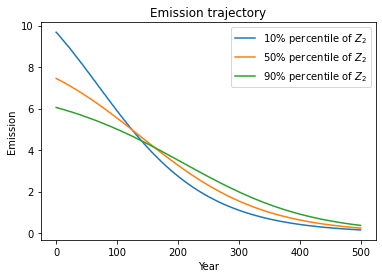

In [34]:
Et_10 = simulate_emission(e_z, r_z, r_start=1500, T=500)
import matplotlib.pyplot as plt
plt.plot(Et_7, label=r'10% percentile of $Z_2$')
plt.plot(Et_10, label=r'50% percentile of $Z_2$')
plt.plot(Et_13, label=r'90% percentile of $Z_2$')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Emission')
plt.title('Emission trajectory')
plt.savefig('plot.pdf')

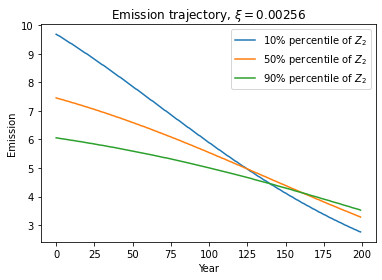

In [36]:
plt.plot(Et_7[:200], label=r'10% percentile of $Z_2$')
plt.plot(Et_10[:200], label=r'50% percentile of $Z_2$')
plt.plot(Et_13[:200], label=r'90% percentile of $Z_2$')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Emission')
plt.title(r'Emission trajectory, $\xi=0.00256$')
plt.savefig('plot_200.pdf')

In [ ]:
# Simulation to compute quantile
# dZ = -ρ*(Z-μ_2)*dt + np.sqrt(Z)*σ_2*dW
def simulate(T=1_000_000):
    Ws = np.random.normal(size=T)
    Z = np.zeros(T)
    Z[0] = μ_2
    for i in range(1, T):
        Z[i] = Z[i-1] + (Z[i-1]-μ_2)*(-ρ) + np.sqrt(Z[i-1])*σ_2*Ws[i]
    return Z

In [ ]:
Z = simulate(T=1_000_000)

In [ ]:
# np.quantile(Z, 0.90)

In [ ]:
0.6994771371520058 # 10%, 7
0.9875416359997453 # 50%, 10
1.3172478454208487 # 90%, 13